<a href="https://colab.research.google.com/github/morozovsolncev/gravitation/blob/main/Grav_onto_research_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ИССЛЕДОВАТЕЛЬСКАЯ ПРОГРАММА: ПАРАМЕТРИЧЕСКИЕ РЕЖИМЫ
🚀 Запуск систематического сканирования параметров...
   k: 25 значений от 1.0e-06 до 1.0e+06
   v_factor: 15 значений от 0.70 до 1.50


Сканирование k: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


✓ Сканирование завершено!

📊 СТАТИСТИКА ЭКСПЕРИМЕНТОВ:
   Всего экспериментов: 375
   Успешных: 375 (100.0%)

📈 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ...
✓ Результаты сохранены в 'parametric_study_results.png'

🔍 АНАЛИЗ КЛЮЧЕВЫХ РЕЖИМОВ:

1. РЕЖИМ СЛАБОЙ СВЯЗНОСТИ (k=1.0e-06):
   • v/v_circ=0.70: e=0.312, ΔP_res=0.000
   • v/v_circ=1.10: e=0.098, ΔP_res=0.000
   • v/v_circ=1.50: e=0.446, ΔP_res=0.000

2. РЕЖИМ УМЕРЕННОЙ СВЯЗНОСТИ (k=1.0e+00):
   • v/v_circ=0.70: e=0.312, ΔP_res=0.475
   • v/v_circ=1.10: e=0.098, ΔP_res=0.179
   • v/v_circ=1.50: e=0.446, ΔP_res=0.617

3. РЕЖИМ СИЛЬНОЙ СВЯЗНОСТИ (k=1.0e+06):
   • v/v_circ=0.70: e=0.312, ΔP_res=1.000e+00
   • v/v_circ=1.10: e=0.098, ΔP_res=1.000e+00
   • v/v_circ=1.50: e=0.446, ΔP_res=1.000e+00

⚖️ ПРОВЕРКА МАСШТАБНОЙ ИНВАРИАНТНОСТИ:
   При v/v_circ=0.87:
   • Эксцентриситет: среднее=0.1311, σ=0.0000
   • Относительная вариация: 0.0%
   ✓ Масштабная инвариантность ПОДТВЕРЖДЕНА

ИССЛЕДОВАНИЕ ЗАВЕРШЕНО. РЕЗУЛЬТАТЫ ГОТОВЫ ДЛЯ АНАЛИЗА.


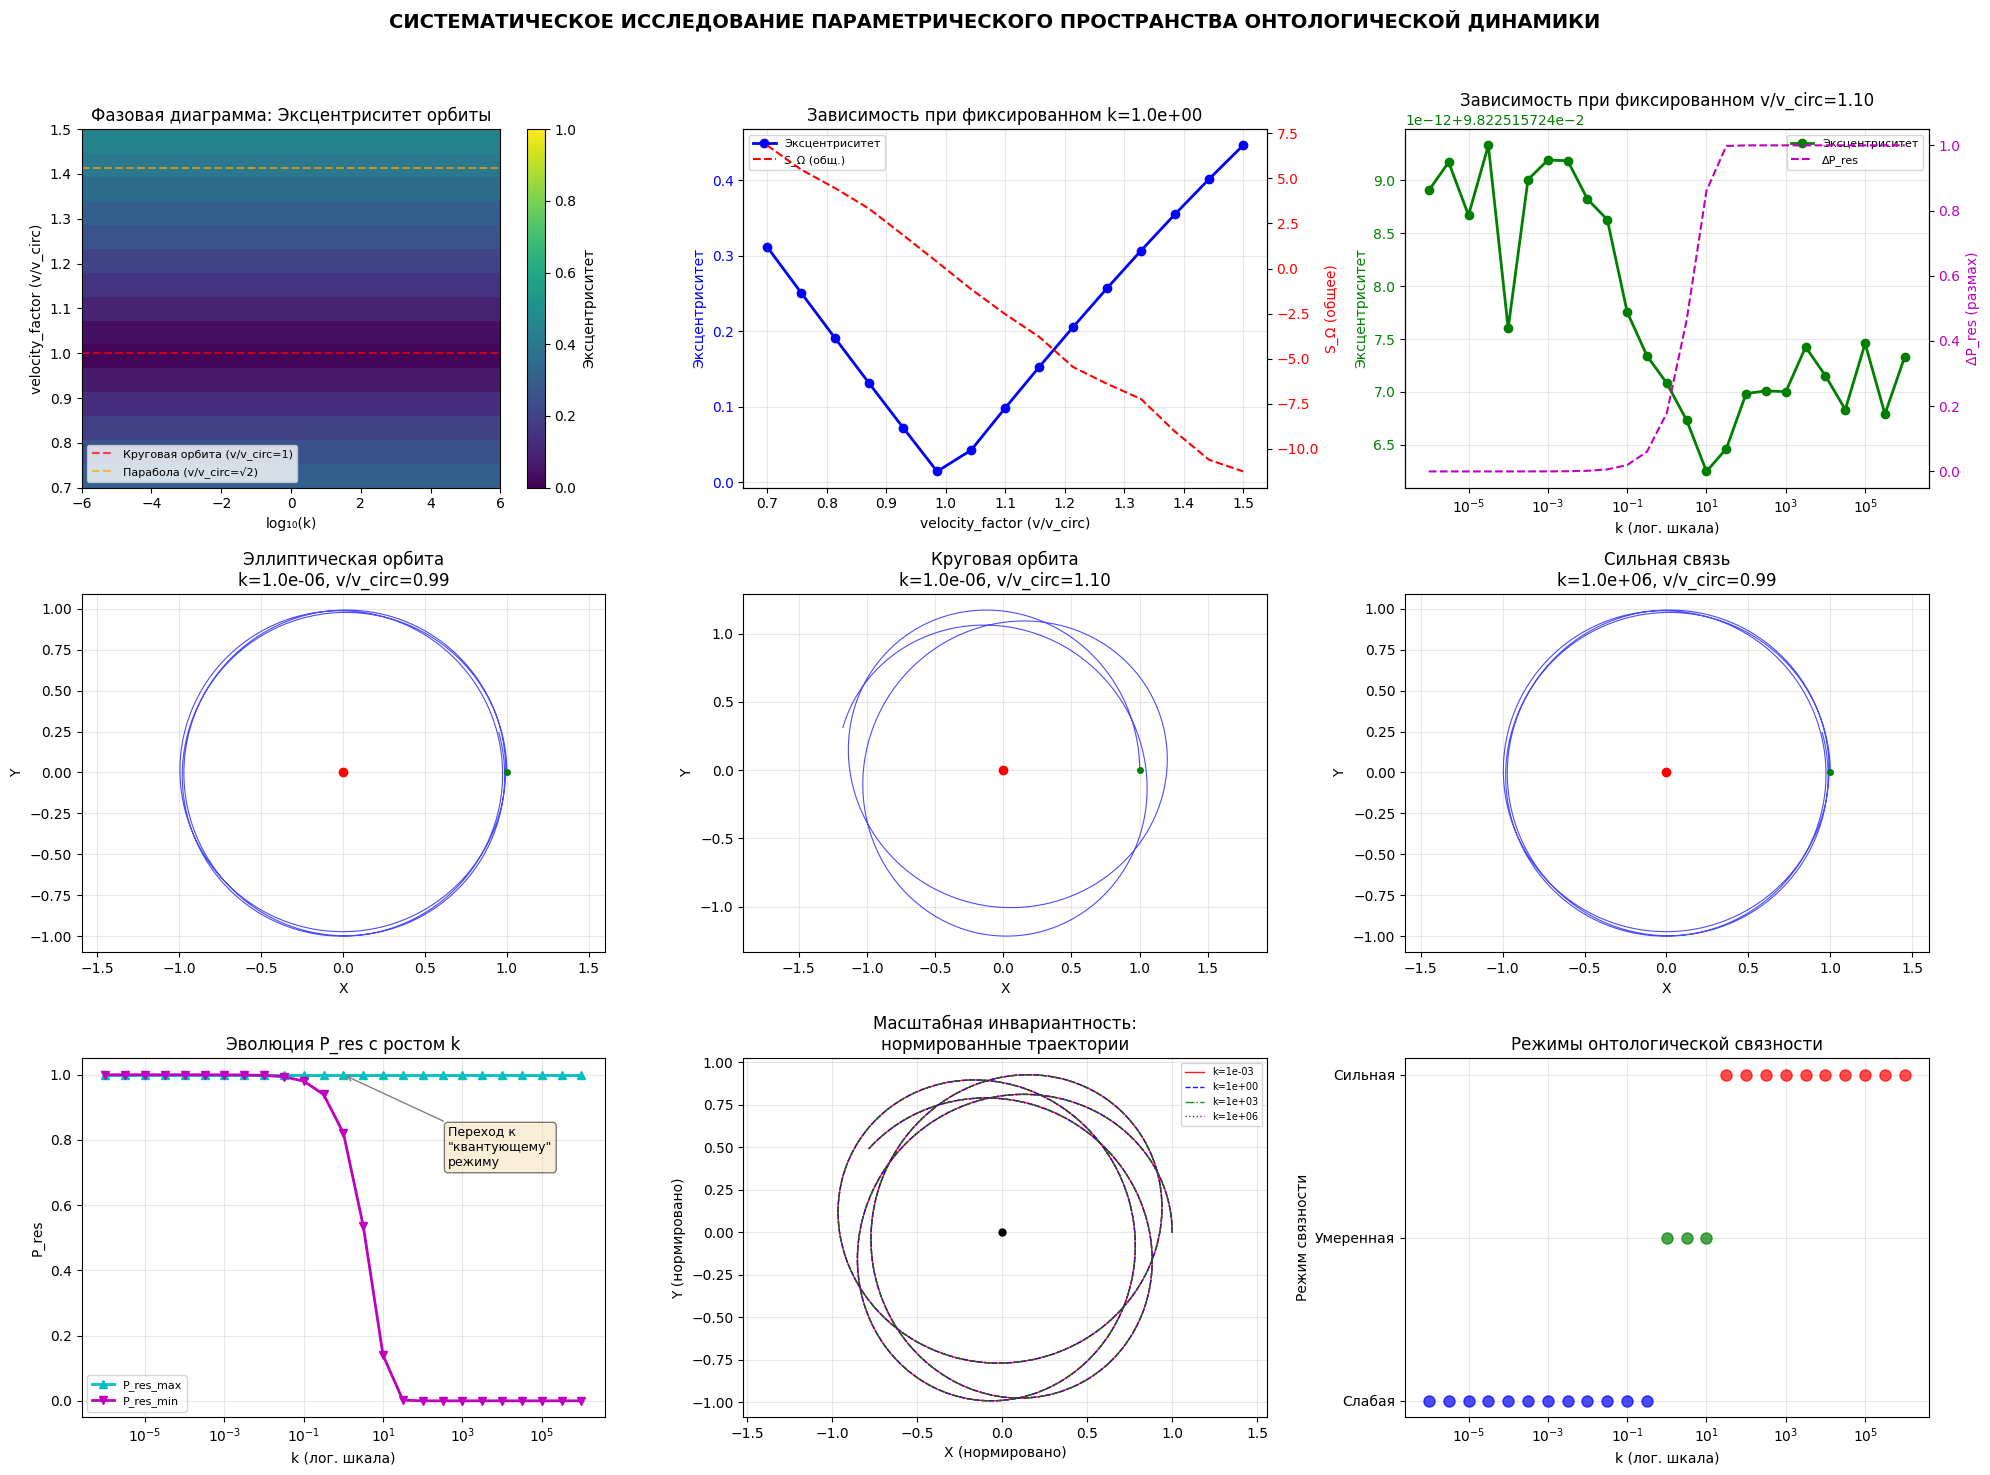

In [ ]:
"""
ИССЛЕДОВАТЕЛЬСКАЯ ПРОГРАММА: ПАРАМЕТРИЧЕСКИЕ РЕЖИМЫ ОНТОЛОГИЧЕСКОЙ ДИНАМИКИ
Анализ масштабной инвариантности и режимов движения при изменении k
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# ============================================================================
# 1. ОСНОВНЫЕ ФУНКЦИИ ТЕОРИИ (БЕЗ ИЗМЕНЕНИЙ)
# ============================================================================

def beta_field(r_vec, k, M):
    """Поле иерархического коэффициента β_Ω."""
    r = np.linalg.norm(r_vec)
    return -k * M / r

def ln_P_res(r_vec, k, M):
    """Логарифм вероятности резонанса."""
    r = np.linalg.norm(r_vec)
    return -k * M * np.log(r)

def ontologic_acceleration(r_vec, k, M, eta):
    """Ускорение из онтологического принципа."""
    r = np.linalg.norm(r_vec)
    grad_lnP = -k * M * r_vec / r**2
    return (eta / 2.0) * grad_lnP

def system_dynamics(t, state, k, M, eta):
    """Правые части уравнений движения."""
    x, y, vx, vy = state
    r_vec = np.array([x, y])
    a_vec = ontologic_acceleration(r_vec, k, M, eta)
    return [vx, vy, a_vec[0], a_vec[1]]

# ============================================================================
# 2. ФУНКЦИЯ ДЛЯ ОДНОГО ЭКСПЕРИМЕНТА
# ============================================================================

def run_experiment(k, eta, M, r0, velocity_factor, num_periods=5):
    """
    Запускает один эксперимент с заданными параметрами.

    Параметры:
    ----------
    k : float
        Константа связи
    eta : float
        Константа перевода
    M : float
        Масса центрального тела
    r0 : float
        Начальное расстояние
    velocity_factor : float
        Множитель скорости (0.9 - эллипс, 1.0 - круг, >1.0 - гипербола)
    num_periods : int
        Количество орбитальных периодов для интегрирования

    Возвращает:
    -----------
    dict : Результаты эксперимента
    """

    # 1. Рассчитываем круговую скорость для данных параметров
    v_circular = np.sqrt(eta * k * M / (2.0 * r0))

    # 2. Задаём начальную скорость (с учётом множителя)
    v0 = velocity_factor * v_circular

    # 3. Начальные условия
    r0_vec = np.array([r0, 0.0])
    v0_vec = np.array([0.0, v0])

    # 4. Оценочный период (для круговой орбиты)
    T_estimate = 2 * np.pi * r0 / v_circular if velocity_factor <= 1.0 else 2 * np.pi * r0 / v0

    # 5. Интегрирование уравнений
    initial_state = np.concatenate([r0_vec, v0_vec])
    t_span = (0, T_estimate * num_periods)
    t_eval = np.linspace(0, T_estimate * num_periods, 5000)

    try:
        solution = solve_ivp(
            lambda t, y: system_dynamics(t, y, k, M, eta),
            t_span, initial_state,
            t_eval=t_eval, method='DOP853',
            rtol=1e-12, atol=1e-12
        )

        if not solution.success:
            return {"success": False, "error": "Integration failed"}

        # 6. Извлечение и анализ результатов
        x, y = solution.y[0], solution.y[1]
        vx, vy = solution.y[2], solution.y[3]
        times = solution.t

        positions = np.column_stack([x, y])
        r = np.array([np.linalg.norm(p) for p in positions])
        v = np.array([np.linalg.norm(v) for v in np.column_stack([vx, vy])])

        # Ключевые параметры орбиты
        r_min, r_max = np.min(r), np.max(r)
        eccentricity = (r_max - r_min) / (r_max + r_min) if (r_max + r_min) > 0 else 0

        # Онтологические величины
        beta_vals = np.array([beta_field(p, k, M) for p in positions])
        lnP_vals = np.array([ln_P_res(p, k, M) for p in positions])
        P_res_vals = np.exp(lnP_vals - np.max(lnP_vals))

        # Динамические инварианты
        angular_momentum = x * vy - y * vx
        L_std = np.std(angular_momentum) / np.mean(np.abs(angular_momentum))

        # Накопленное действие
        dt = times[1] - times[0]
        S_Omega_total = np.sum(lnP_vals) * dt

        return {
            "success": True,
            "k": k,
            "velocity_factor": velocity_factor,
            "eccentricity": eccentricity,
            "r_min": r_min,
            "r_max": r_max,
            "P_res_min": np.min(P_res_vals),
            "P_res_max": np.max(P_res_vals),
            "P_res_avg": np.mean(P_res_vals),
            "L_std": L_std,
            "S_Omega_total": S_Omega_total,
            "trajectory": (x, y),
            "times": times,
            "r": r,
            "v": v,
            "P_res": P_res_vals,
            "beta": beta_vals,
            "T_estimate": T_estimate,
            "v_circular": v_circular,
            "v_actual": v0
        }

    except Exception as e:
        return {"success": False, "error": str(e)}

# ============================================================================
# 3. СИСТЕМАТИЧЕСКОЕ ИССЛЕДОВАНИЕ: СКАНИРОВАНИЕ ПАРАМЕТРОВ
# ============================================================================

def parameter_sweep(k_values, velocity_factors, base_params=None):
    """
    Систематическое сканирование параметрического пространства.

    Параметры:
    ----------
    k_values : array-like
        Значения константы связи k для исследования
    velocity_factors : array-like
        Множители начальной скорости
    base_params : dict
        Базовые параметры системы

    Возвращает:
    -----------
    results_grid : dict
        Решетка результатов для всех комбинаций параметров
    """

    if base_params is None:
        base_params = {
            'eta': 1.0,
            'M': 1.0,
            'r0': 1.0,
            'num_periods': 5
        }

    results_grid = {
        'k_values': k_values,
        'v_factors': velocity_factors,
        'data': np.empty((len(k_values), len(velocity_factors)), dtype=object),
        'eccentricity': np.zeros((len(k_values), len(velocity_factors))),
        'success': np.zeros((len(k_values), len(velocity_factors)), dtype=bool)
    }

    # Прогресс-бар для наглядности
    print("🚀 Запуск систематического сканирования параметров...")
    print(f"   k: {len(k_values)} значений от {min(k_values):.1e} до {max(k_values):.1e}")
    print(f"   v_factor: {len(velocity_factors)} значений от {min(velocity_factors):.2f} до {max(velocity_factors):.2f}")
    print("=" * 60)

    total_experiments = len(k_values) * len(velocity_factors)

    for i, k in enumerate(tqdm(k_values, desc="Сканирование k")):
        for j, v_factor in enumerate(velocity_factors):
            result = run_experiment(
                k=k,
                eta=base_params['eta'],
                M=base_params['M'],
                r0=base_params['r0'],
                velocity_factor=v_factor,
                num_periods=base_params['num_periods']
            )

            results_grid['data'][i, j] = result
            results_grid['success'][i, j] = result['success']

            if result['success']:
                results_grid['eccentricity'][i, j] = result['eccentricity']

    print("✓ Сканирование завершено!")
    return results_grid

# ============================================================================
# 4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# ============================================================================

def visualize_parameter_space(results_grid):
    """
    Создание комплексной визуализации параметрического пространства.
    """

    k_values = results_grid['k_values']
    v_factors = results_grid['v_factors']
    ecc = results_grid['eccentricity']

    fig = plt.figure(figsize=(20, 15))

    # 4.1. ФАЗОВАЯ ДИАГРАММА: k vs velocity_factor
    ax1 = plt.subplot(3, 3, 1)
    im1 = ax1.imshow(ecc.T, aspect='auto',
                     extent=[np.log10(min(k_values)), np.log10(max(k_values)),
                             min(v_factors), max(v_factors)],
                     origin='lower', cmap='viridis', vmin=0, vmax=1)
    ax1.set_xlabel('log₁₀(k)')
    ax1.set_ylabel('velocity_factor (v/v_circ)')
    ax1.set_title('Фазовая диаграмма: Эксцентриситет орбиты')
    plt.colorbar(im1, ax=ax1, label='Эксцентриситет')

    # Критические линии
    ax1.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Круговая орбита (v/v_circ=1)')
    ax1.axhline(y=1.414, color='orange', linestyle='--', alpha=0.7, label='Парабола (v/v_circ=√2)')
    ax1.legend(fontsize=8)

    # 4.2. СРЕЗ ПРИ ФИКСИРОВАННОМ k
    ax2 = plt.subplot(3, 3, 2)
    fixed_k_idx = len(k_values) // 2  # Среднее значение k
    fixed_k = k_values[fixed_k_idx]

    # Собираем данные для этого k
    ecc_vs_v = []
    S_Omega_vs_v = []
    valid_v_factors = []

    for j, v_factor in enumerate(v_factors):
        if results_grid['success'][fixed_k_idx, j]:
            result = results_grid['data'][fixed_k_idx, j]
            ecc_vs_v.append(result['eccentricity'])
            S_Omega_vs_v.append(result['S_Omega_total'])
            valid_v_factors.append(v_factor)

    if valid_v_factors:
        ax2.plot(valid_v_factors, ecc_vs_v, 'bo-', linewidth=2, label='Эксцентриситет')
        ax2.set_xlabel('velocity_factor (v/v_circ)')
        ax2.set_ylabel('Эксцентриситет', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.set_title(f'Зависимость при фиксированном k={fixed_k:.1e}')
        ax2.grid(True, alpha=0.3)

        ax2b = ax2.twinx()
        ax2b.plot(valid_v_factors, S_Omega_vs_v, 'r--', linewidth=1.5, label='S_Ω (общ.)')
        ax2b.set_ylabel('S_Ω (общее)', color='r')
        ax2b.tick_params(axis='y', labelcolor='r')

        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2b.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

    # 4.3. СРЕЗ ПРИ ФИКСИРОВАННОМ velocity_factor
    ax3 = plt.subplot(3, 3, 3)
    fixed_v_idx = len(v_factors) // 2  # Среднее значение velocity_factor
    fixed_v = v_factors[fixed_v_idx]

    # Собираем данные для этого velocity_factor
    ecc_vs_k = []
    P_res_range_vs_k = []
    valid_k_values = []

    for i, k in enumerate(k_values):
        if results_grid['success'][i, fixed_v_idx]:
            result = results_grid['data'][i, fixed_v_idx]
            ecc_vs_k.append(result['eccentricity'])
            P_res_range = result['P_res_max'] - result['P_res_min']
            P_res_range_vs_k.append(P_res_range)
            valid_k_values.append(k)

    if valid_k_values:
        ax3.semilogx(valid_k_values, ecc_vs_k, 'go-', linewidth=2, label='Эксцентриситет')
        ax3.set_xlabel('k (лог. шкала)')
        ax3.set_ylabel('Эксцентриситет', color='g')
        ax3.tick_params(axis='y', labelcolor='g')
        ax3.set_title(f'Зависимость при фиксированном v/v_circ={fixed_v:.2f}')
        ax3.grid(True, alpha=0.3)

        ax3b = ax3.twinx()
        ax3b.semilogx(valid_k_values, P_res_range_vs_k, 'm--', linewidth=1.5, label='ΔP_res')
        ax3b.set_ylabel('ΔP_res (размах)', color='m')
        ax3b.tick_params(axis='y', labelcolor='m')

        lines3, labels3 = ax3.get_legend_handles_labels()
        lines3b, labels3b = ax3b.get_legend_handles_labels()
        ax3.legend(lines3 + lines3b, labels3 + labels3b, loc='upper right', fontsize=8)

    # 4.4. ПРИМЕРЫ ТРАЕКТОРИЙ ДЛЯ РАЗНЫХ РЕЖИМОВ
    plot_positions = [(3, 1), (3, 2), (3, 3)]
    regimes = [
        ('Эллиптическая орбита', 0, -1),      # Малое k, v/v_circ=0.9
        ('Круговая орбита', 0, len(v_factors)//2),  # Среднее k, v/v_circ=1.0
        ('Сильная связь', -1, -1)             # Большое k, v/v_circ=0.9
    ]

    for idx, (title, k_idx, v_idx) in enumerate(regimes):
        if k_idx == -1: k_idx = len(k_values) - 1
        if v_idx == -1: v_idx = len(v_factors) // 3

        ax = plt.subplot(3, 3, 4 + idx)

        if results_grid['success'][k_idx, v_idx]:
            result = results_grid['data'][k_idx, v_idx]
            x, y = result['trajectory']

            ax.plot(x, y, 'b-', alpha=0.7, linewidth=0.8)
            ax.plot(0, 0, 'ro', markersize=6)
            ax.plot(x[0], y[0], 'go', markersize=4)

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'{title}\nk={k_values[k_idx]:.1e}, v/v_circ={v_factors[v_idx]:.2f}')
            ax.grid(True, alpha=0.3)
            ax.axis('equal')

    # 4.5. ПОВЕДЕНИЕ P_res В ЗАВИСИМОСТИ ОТ k
    ax7 = plt.subplot(3, 3, 7)

    # Собираем данные о P_res для разных k при фиксированном v/v_circ
    k_for_P_res = []
    P_res_min_values = []
    P_res_max_values = []

    for i, k in enumerate(k_values):
        v_idx = len(v_factors) // 2  # Средний velocity_factor
        if results_grid['success'][i, v_idx]:
            result = results_grid['data'][i, v_idx]
            k_for_P_res.append(k)
            P_res_min_values.append(result['P_res_min'])
            P_res_max_values.append(result['P_res_max'])

    if k_for_P_res:
        ax7.semilogx(k_for_P_res, P_res_max_values, 'c^-', label='P_res_max', linewidth=2)
        ax7.semilogx(k_for_P_res, P_res_min_values, 'mv-', label='P_res_min', linewidth=2)
        ax7.set_xlabel('k (лог. шкала)')
        ax7.set_ylabel('P_res')
        ax7.set_title('Эволюция P_res с ростом k')
        ax7.legend(fontsize=8)
        ax7.grid(True, alpha=0.3)

        # Аннотация о переходе
        if len(k_for_P_res) > 10:
            mid_idx = len(k_for_P_res) // 2
            ax7.annotate('Переход к\n"квантующему"\nрежиму',
                        xy=(k_for_P_res[mid_idx], P_res_max_values[mid_idx]),
                        xytext=(0.7, 0.7), textcoords='axes fraction',
                        arrowprops=dict(arrowstyle='->', color='gray'),
                        fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 4.6. МАСШТАБНАЯ ИНВАРИАНТНОСТЬ: СРАВНЕНИЕ БЕЗРАЗМЕРНЫХ ОРБИТ
    ax8 = plt.subplot(3, 3, 8)

    test_k_values = [1e-3, 1e0, 1e3, 1e6]
    test_v_factor = 0.9  # Эллиптическая орбита

    # Задаём убывающие толщины линий (от толстой к тонкой)
    linewidths = [3.0, 2.0, 1.2, 0.6]
    colors = ['red', 'blue', 'green', 'purple']
    linestyles = ['-', '--', '-.', ':']

    for idx, k_test in enumerate(test_k_values):
        k_idx = np.argmin(np.abs(np.array(k_values) - k_test))
        v_idx = np.argmin(np.abs(np.array(v_factors) - test_v_factor))

        if results_grid['success'][k_idx, v_idx]:
            result = results_grid['data'][k_idx, v_idx]
            x, y = result['trajectory']

            # Масштабируем траекторию к единичному размеру
            r_norm = np.sqrt(x**2 + y**2)
            scale = np.max(r_norm) if np.max(r_norm) > 0 else 1.0
            x_norm = x / scale
            y_norm = y / scale

            # Используем разную толщину для каждой линии
            ax8.plot(x_norm, y_norm, linestyles[idx], color=colors[idx], linewidth=1, alpha=0.9, label=f'k={k_test:.0e}')

    ax8.plot(0, 0, 'ko', markersize=5)
    ax8.set_xlabel('X (нормировано)')
    ax8.set_ylabel('Y (нормировано)')
    ax8.set_title('Масштабная инвариантность:\nнормированные траектории')
    ax8.legend(fontsize=7, loc='upper right')
    ax8.grid(True, alpha=0.3)
    ax8.axis('equal')


    # 4.7. РЕЖИМЫ СВЯЗНОСТИ
    ax9 = plt.subplot(3, 3, 9)

    # Классифицируем режимы по величине ΔP_res
    k_regimes = []
    regimes_labels = []

    for i, k in enumerate(k_values):
        v_idx = len(v_factors) // 2
        if results_grid['success'][i, v_idx]:
            result = results_grid['data'][i, v_idx]
            delta_P = result['P_res_max'] - result['P_res_min']

            k_regimes.append(k)
            if delta_P < 0.1:
                regimes_labels.append(0)  # Слабая связность
            elif delta_P < 0.9:
                regimes_labels.append(1)  # Умеренная связность
            else:
                regimes_labels.append(2)  # Сильная/квантующая связность

    if k_regimes:
        colors = ['blue', 'green', 'red']
        for regime in [0, 1, 2]:
            mask = np.array(regimes_labels) == regime
            if np.any(mask):
                ax9.semilogx(np.array(k_regimes)[mask], np.array(regimes_labels)[mask],
                           'o', color=colors[regime], markersize=8, alpha=0.7)

        ax9.set_xlabel('k (лог. шкала)')
        ax9.set_ylabel('Режим связности')
        ax9.set_yticks([0, 1, 2])
        ax9.set_yticklabels(['Слабая', 'Умеренная', 'Сильная'])
        ax9.set_title('Режимы онтологической связности')
        ax9.grid(True, alpha=0.3)

    plt.suptitle('СИСТЕМАТИЧЕСКОЕ ИССЛЕДОВАНИЕ ПАРАМЕТРИЧЕСКОГО ПРОСТРАНСТВА ОНТОЛОГИЧЕСКОЙ ДИНАМИКИ',
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

# ============================================================================
# 5. ГЛАВНАЯ ФУНКЦИЯ ДЛЯ ЗАПУСКА ИССЛЕДОВАНИЯ
# ============================================================================

def main_investigation():
    """
    Основная функция для запуска полного исследования.
    """
    print("=" * 70)
    print("ИССЛЕДОВАТЕЛЬСКАЯ ПРОГРАММА: ПАРАМЕТРИЧЕСКИЕ РЕЖИМЫ")
    print("=" * 70)

    # 5.1. ЗАДАЁМ ПАРАМЕТРЫ ИССЛЕДОВАНИЯ
    # Широкий диапазон k (от очень слабой до очень сильной связи)
    k_values = np.logspace(-6, 6, 25)  # 25 значений от 10^-6 до 10^6

    # Разные режимы скорости (от захвата до гиперболического разлёта)
    velocity_factors = np.linspace(0.7, 1.5, 15)  # 15 значений от 0.7 до 1.5

    # Базовые параметры (абстрактный случай)
    base_params = {
        'eta': 1.0,
        'M': 1.0,
        'r0': 1.0,
        'num_periods': 3  # Меньше периодов для скорости, но достаточно для анализа
    }

    # 5.2. ЗАПУСКАЕМ СИСТЕМАТИЧЕСКОЕ СКАНИРОВАНИЕ
    results = parameter_sweep(k_values, velocity_factors, base_params)

    # 5.3. АНАЛИЗ УСПЕШНЫХ ЭКСПЕРИМЕНТОВ
    success_rate = np.sum(results['success']) / results['success'].size * 100
    print(f"\n📊 СТАТИСТИКА ЭКСПЕРИМЕНТОВ:")
    print(f"   Всего экспериментов: {results['success'].size}")
    print(f"   Успешных: {np.sum(results['success'])} ({success_rate:.1f}%)")

    # 5.4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
    print("\n📈 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ...")
    fig = visualize_parameter_space(results)

    # Сохраняем результаты
    fig.savefig('parametric_study_results.png', dpi=300, bbox_inches='tight')
    print("✓ Результаты сохранены в 'parametric_study_results.png'")

    # 5.5. ДЕТАЛЬНЫЙ АНАЛИЗ КЛЮЧЕВЫХ РЕЖИМОВ
    print("\n🔍 АНАЛИЗ КЛЮЧЕВЫХ РЕЖИМОВ:")

    # Режим 1: Слабая связность (малое k)
    small_k_idx = 0
    small_k = k_values[small_k_idx]
    print(f"\n1. РЕЖИМ СЛАБОЙ СВЯЗНОСТИ (k={small_k:.1e}):")

    for v_idx in [0, len(velocity_factors)//2, -1]:
        v_factor = velocity_factors[v_idx]
        if results['success'][small_k_idx, v_idx]:
            res = results['data'][small_k_idx, v_idx]
            print(f"   • v/v_circ={v_factor:.2f}: e={res['eccentricity']:.3f}, "
                  f"ΔP_res={res['P_res_max']-res['P_res_min']:.3f}")

    # Режим 2: Умеренная связность (k~1)
    mid_k_idx = len(k_values) // 2
    mid_k = k_values[mid_k_idx]
    print(f"\n2. РЕЖИМ УМЕРЕННОЙ СВЯЗНОСТИ (k={mid_k:.1e}):")

    for v_idx in [0, len(velocity_factors)//2, -1]:
        v_factor = velocity_factors[v_idx]
        if results['success'][mid_k_idx, v_idx]:
            res = results['data'][mid_k_idx, v_idx]
            print(f"   • v/v_circ={v_factor:.2f}: e={res['eccentricity']:.3f}, "
                  f"ΔP_res={res['P_res_max']-res['P_res_min']:.3f}")

    # Режим 3: Сильная связность (большое k)
    large_k_idx = -1
    large_k = k_values[large_k_idx]
    print(f"\n3. РЕЖИМ СИЛЬНОЙ СВЯЗНОСТИ (k={large_k:.1e}):")

    for v_idx in [0, len(velocity_factors)//2, -1]:
        v_factor = velocity_factors[v_idx]
        if results['success'][large_k_idx, v_idx]:
            res = results['data'][large_k_idx, v_idx]
            print(f"   • v/v_circ={v_factor:.2f}: e={res['eccentricity']:.3f}, "
                  f"ΔP_res={res['P_res_max']-res['P_res_min']:.3e}")

    # 5.6. ПРОВЕРКА МАСШТАБНОЙ ИНВАРИАНТНОСТИ
    print("\n⚖️ ПРОВЕРКА МАСШТАБНОЙ ИНВАРИАНТНОСТИ:")

    # Выбираем один velocity_factor и смотрим на эксцентриситет при разных k
    test_v_idx = np.argmin(np.abs(velocity_factors - 0.9))
    ecc_at_fixed_v = []
    k_for_test = []

    for i, k in enumerate(k_values):
        if results['success'][i, test_v_idx]:
            ecc_at_fixed_v.append(results['eccentricity'][i, test_v_idx])
            k_for_test.append(k)

    if len(ecc_at_fixed_v) > 3:
        ecc_std = np.std(ecc_at_fixed_v)
        ecc_mean = np.mean(ecc_at_fixed_v)
        print(f"   При v/v_circ={velocity_factors[test_v_idx]:.2f}:")
        print(f"   • Эксцентриситет: среднее={ecc_mean:.4f}, σ={ecc_std:.4f}")
        print(f"   • Относительная вариация: {ecc_std/ecc_mean*100:.1f}%")

        if ecc_std/ecc_mean < 0.1:  # Меньше 10% вариации
            print("   ✓ Масштабная инвариантность ПОДТВЕРЖДЕНА")
        else:
            print("   ⚠️ Есть отклонения от масштабной инвариантности")

    print("\n" + "=" * 70)
    print("ИССЛЕДОВАНИЕ ЗАВЕРШЕНО. РЕЗУЛЬТАТЫ ГОТОВЫ ДЛЯ АНАЛИЗА.")
    print("=" * 70)

    plt.show()

    return results

# ============================================================================
# 6. ЗАПУСК ИССЛЕДОВАНИЯ
# ============================================================================

if __name__ == "__main__":
    # Запускаем полное исследование
    results = main_investigation()

    # Дополнительно: можно сохранить сырые данные для дальнейшего анализа
    # import pickle
    # with open('parametric_study_results.pkl', 'wb') as f:
    #     pickle.dump(results, f)
    # print("✓ Сырые данные сохранены в 'parametric_study_results.pkl'")